# Generative Models

# Autoencoders

Today we will use `keras` in `tensorflow` to build autoencoders. 

We will start with a simple neural network architecture that is composed of an input layer a lower-dimensional latent space, and an output layer of equal size.

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png" width="400" />

Autoencoders are an *unsupervised learning* method. We will begin by using an autoencoder to create a latent space representation of the `digits` dataset, a reduced-dimension version of the `MNIST` dataset. Replacing the `digits` dataset with the larger `MNIST` dataset is perhaps a more useful activity, but increases the runtime of the algorithm.

We will then extend this to create an autoencoder for the AT-TPC data.

In [124]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets, cluster # for k-means clustering
from sklearn.cluster import KMeans
import random # if we want to create a Variational Autoencoder
# This is simply an alias for convenience
layers = tf.keras.layers


In [125]:
# useful functions

def load_attpc_data():
    """Loads in the AT-TPC data.
        
    Returns:
        A tuple of the form ((real_features, real_targets), (simulated_features, simulated_targets))
    """
    simulated_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5'
    real_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/real-attpc-events.h5'
    
    simulated_path = tf.keras.utils.get_file('simulated-attpc-data.h5', origin=simulated_data_origin)
    real_path = tf.keras.utils.get_file('real-attpc-data.h5', origin=real_data_origin)
    
    with h5py.File(simulated_path, 'r') as h5:
        simulated_features = h5['features'][:]
        simulated_targets = h5['targets'][:]
        
    with h5py.File(real_path, 'r') as h5:
        real_features = h5['features'][:]
        real_targets = h5['targets'][:]
    
    return (real_features, real_targets), (simulated_features, simulated_targets)

def plot_learning_curve(history):
    """Plots a learning curve from a training history.
    
    Arguments:
        history (dict): The training history returned by `model.fit()`.
        
    Returns:
        None.
    """
    plt.figure(figsize=(11, 6), dpi=100)
    plt.plot(history.history['loss'], 'o-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'o:', color='r', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))
    plt.show()
    


## Data exploration

Again, we begin by loading our data, normalizing it, and putting it intot he approporate format for our model. In this case, we need 1D arrays for our fully connected architecture. 

In [126]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [127]:
print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(x_train.shape, x_train.dtype))

Training Features:
   Shape: (60000, 28, 28)
   Type: uint8



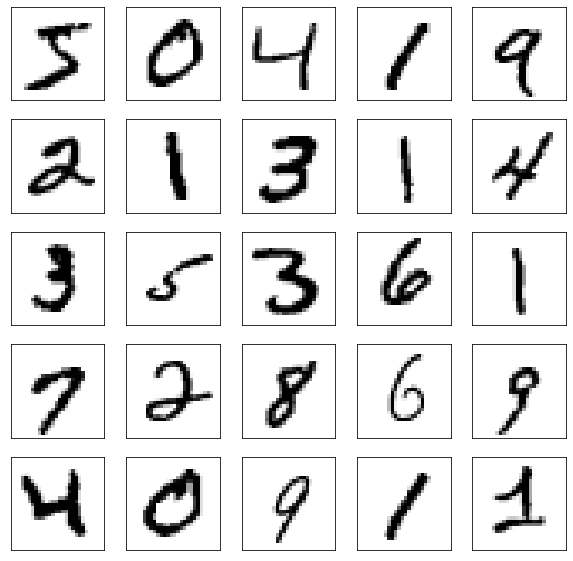

In [128]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    
plt.show()

### As always, we much rescale the data. Here, I rescaled the images to [0,1]

In [130]:
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


Now we build the autoencoder. Ours is a standard feed-forward neural network architecture with three layers as descibed above.

Let's start by reducing our dimensionality by a factor of two and see if we can recover our original images.

One way to build an autoencoder is to store each layer into a variable so that we can access the different pieces later. 

*Note: I achieved my best performance with a `relu` activation function on both the encoded and output layers.*

In [131]:
latent_dim = 128

input_img = layers.Input(shape=(784,))

latent_layer = layers.Dense(latent_dim, activation="relu")(input_img)


latent_input = layers.Input(shape=(latent_dim,))

output_layer = layers.Dense(784, activation='relu')(latent_input)

## Now, we build the encoder and decoder from the same layers.

Let's start with the encoder:

In [132]:
# this model maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, latent_layer)

Now, for the decoder. This requires slightly more work because we want to have a latent representation as an Input in order to use the decoder as a generator.

In [133]:
# create a placeholder for an encoded (32-dimensional) input
latent_input = layers.Input(shape=(latent_dim,))

out = layers.Dense(784, activation='relu')(latent_input)
decoder = tf.keras.models.Model(latent_input, out)


# put the layers together to create your Model
autoencoder = tf.keras.models.Model(input_img, decoder(encoder(input_img)))

### Build the model...

In [134]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Now, train!

In [135]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 2/40
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 3/40
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0040 - val_loss: 0.0041
Epoch 4/40
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 5/40
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0040 - val_loss: 0.0041
Epoch 6/40
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 7/40
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 8/40
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0039 - val_loss: 0.0040
Epoch 9/40
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0039 - val

In [136]:
# encode and decode digits from the test det

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

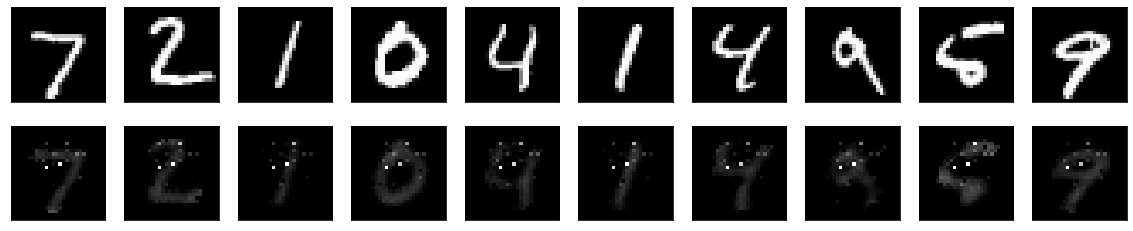

In [137]:

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### We can try k-means clustering on the latent space to see if we can separate numbers

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [122]:
clust = KMeans(n_clusters=10).fit(x_test)

[2 4 3 ... 2 2 5]
[2 4 3 ... 2 2 5]


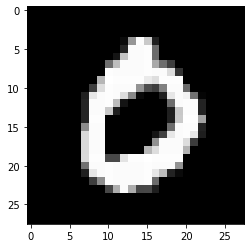

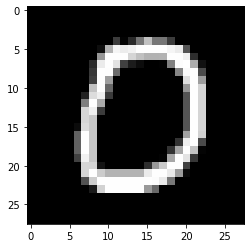

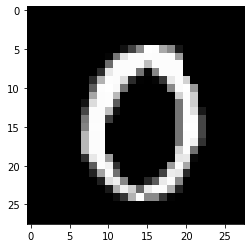

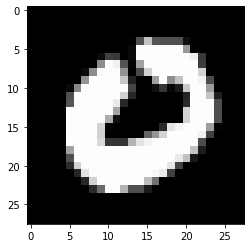

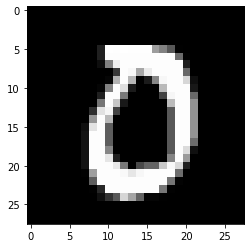

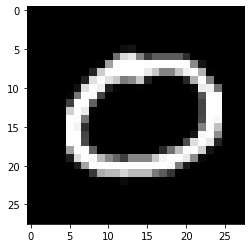

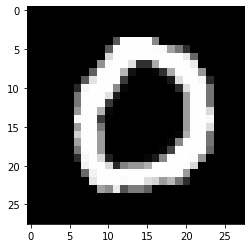

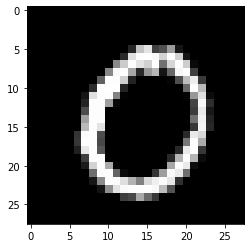

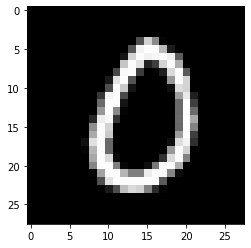

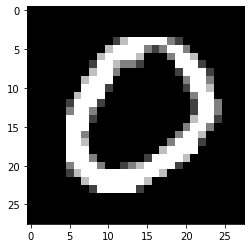

In [123]:
print(clust.labels_)
print(clust.predict(x_test))
#print(clust.cluster_centers_)
ind = np.where(clust.labels_ == 9)[0][:10]
for i in ind:
    plt.imshow(x_test[i].reshape((28,28)))
    plt.show()

# AT-TPC data

Now that you have some experience, try to build an autoencoder from the AT-TPC data! I am leaving this open-ended so that you can think through all of the necessary steps and choices.

First, we load real and simulated data:

In [138]:
(real_features, _), (sim_features, _) = load_attpc_data()

Let's remind ourselves of the shaps of this data:

In [139]:
print('Real Features:\n   Shape: {}\n   Type: {}\n'.format(real_features.shape, real_features.dtype))
print('Simulated Features:\n   Shape: {}\n   Type: {}\n'.format(sim_features.shape, sim_features.dtype))


Real Features:
   Shape: (2689, 128, 128)
   Type: uint8

Simulated Features:
   Shape: (50000, 128, 128)
   Type: uint8



If running this notebook on Google Colab, you will not be able to fit all 50,000 simulated events in RAM after they have been normalized. Run the cell below to use only 10,000.

In [140]:
sim_features = sim_features[:10000]

#### Experimental data

We visualize the first 25 examples from the experimental dataset below. We no longer have class information.

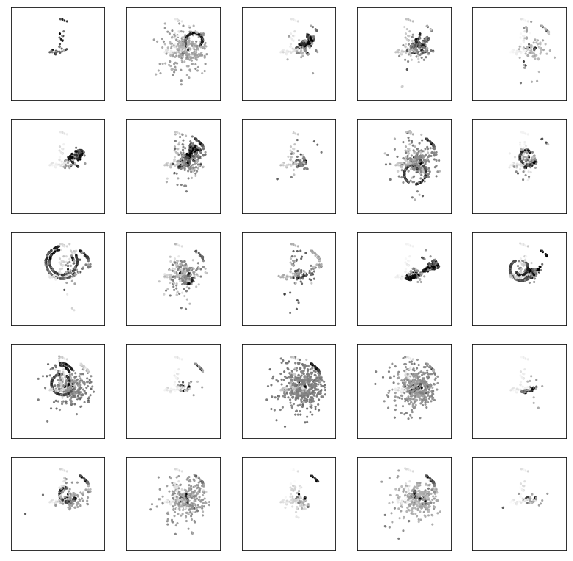

In [142]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(real_features[i], cmap='gray')
    
plt.show()

#### Simulated data

And now we again visualize the first 25 examples from the simulated dataset.

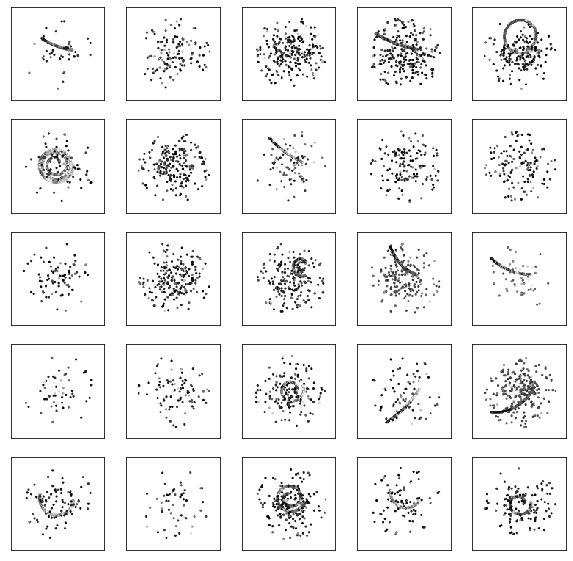

In [144]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_features[i], cmap='gray')
    
plt.show()

### And now, I leave you to think through the next steps!

*(Hint, don't forget to preprocess your data!)*